In [76]:
import pandas as pd
import itertools
import time
import json
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
import seaborn as sns
import shutil

In [77]:

df_evaluation = pd.read_csv("./tunning/evaluation.csv",sep=";")
df_evaluation.head()

,models_filename,type_model,windows,dim_emb,tag_mse,ref_err_dis_cos,ref_rmse_dis_cos,ref_err_moy_freq,ref_rmse_freq
0,skipgramm_9_150.kv,skipgramm,9,150,0.152236,-0.733524,0.752030,0.325559,0.489653
1,glove_10_50.kv,glove,10,50,0.134375,0.237388,0.312297,0.392250,0.512343
2,skipgramm_8_50.kv,skipgramm,8,50,0.148428,-0.720908,0.741574,0.329218,0.491595
3,glove_7_30.kv,glove,7,30,0.140853,0.225437,0.334514,0.366774,0.487065
4,skipgramm_8_10.kv,skipgramm,8,10,0.135562,-0.701923,0.722056,0.313632,0.472125


# Tag similarity

In [78]:
df_tag_similarity = pd.read_csv("tunning/tag_similiraty.csv",sep=";",index_col=0)
df_tag_similarity.head()

,lav,tchouk,lucratif,neon,delivrer,fitnes,carte,inutilise,gm,fraicheur,...,bled,suggerer,mensonger,imposer,barquette,positionner,integralement,crique,carter,droit
lav,1.000000,0.617213,0.231455,0.641689,0.579066,0.617213,0.735634,0.572822,0.462910,0.555584,...,0.462910,0.540062,0.455842,0.783578,0.661495,0.338062,0.755929,0.338062,0.540062,0.737440
tchouk,0.617213,1.000000,0.166667,0.594089,0.384900,0.666667,0.412002,0.353553,0.166667,0.327327,...,0.333333,0.333333,0.246183,0.571366,0.396942,0.182574,0.714435,0.182574,0.333333,0.589028
lucratif,0.231455,0.166667,1.000000,0.297044,0.481125,0.000000,0.294287,0.294628,0.000000,0.218218,...,0.166667,0.166667,0.369274,0.406175,0.132314,0.000000,0.204124,0.365148,0.166667,0.361449
neon,0.641689,0.594089,0.297044,1.000000,0.514496,0.396059,0.582776,0.630126,0.297044,0.518563,...,0.495074,0.693103,0.438763,0.831287,0.581686,0.325396,0.727607,0.216930,0.594089,0.731681
delivrer,0.579066,0.384900,0.481125,0.514496,1.000000,0.192450,0.656973,0.544331,0.384900,0.566947,...,0.481125,0.481125,0.497468,0.777571,0.626411,0.316228,0.471405,0.632456,0.673575,0.664692


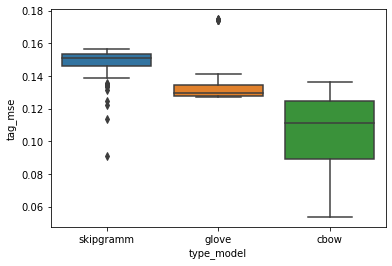

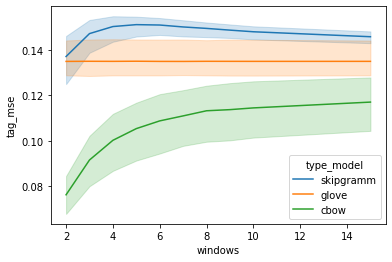

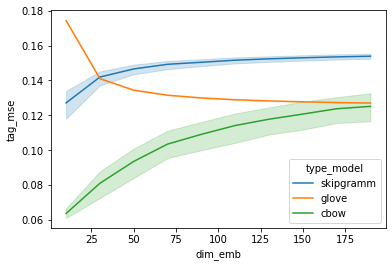

In [79]:
sns.boxplot(x="type_model",y="tag_mse",data=df_evaluation)
plt.show()
sns.lineplot(x="windows",y="tag_mse",hue="type_model",data=df_evaluation)
plt.show()
sns.lineplot(x="dim_emb",y="tag_mse",hue="type_model",data=df_evaluation)
plt.show()

In [80]:
# Best model
best_models = df_evaluation.loc[df_evaluation.groupby("type_model")["tag_mse"].idxmin()]
print(best_models)
best_glove_filename = best_models.loc[best_models["type_model"] == "glove"]["models_filename"].values[0]
best_cbow_filename = best_models["models_filename"].loc[best_models["type_model"] == "cbow"].values[0]
best_skipgram_filename = best_models["models_filename"].loc[best_models["type_model"] == "skipgram"].values[0]

#Load model as Keyedvectors
best_glove = KeyedVectors.load_word2vec_format(f"training_models/{best_glove_filename}")
best_cbow = KeyedVectors.load_word2vec_format(f"training_models/{best_cbow_filename}")
best_skipgram = KeyedVectors.load_word2vec_format(f"training_models/{best_skipgram_filename}")

       models_filename type_model  windows  dim_emb   tag_mse  \
83        cbow_2_30.kv       cbow        2       30  0.053783   
209     glove_2_190.kv      glove        2      190  0.126940   
156  skipgramm_2_10.kv  skipgramm        2       10  0.091147   

     ref_err_dis_cos  ref_rmse_dis_cos  ref_err_moy_freq  ref_rmse_freq  
83         -0.582375          0.635884          0.224780       0.385784  
209         0.236418          0.295074          0.405391       0.522233  
156        -0.675125          0.702858          0.234600       0.387508  


In [81]:
lemm_test = "dechet"

print(f"Glove most similaire to {lemm_test}: \n{best_glove.most_similar(lemm_test)}\n")
print(f"Cbow most similaire to {lemm_test}: \n{best_cbow.most_similar(lemm_test)}\n")
print(f"skipgram most similaire to {lemm_test}: \n{best_skipgram.most_similar(lemm_test)}")

Glove most similaire to dechet: 
[('senat', 0.2794499099254608), ('etat', 0.2562149167060852), ('emergence', 0.22081968188285828), ('spontan', 0.21975696086883545), ('seveso', 0.2190929502248764), ('selectif', 0.2143162041902542), ('navette', 0.21381334960460663), ('polluscore', 0.21232102811336517), ('perir', 0.2108365148305893), ('minimaliste', 0.20986869931221008)]

Cbow most similaire to dechet: 
[('faire', 0.9995613694190979), ('être', 0.9995603561401367), ('exemple', 0.9995468854904175), ('urbain', 0.9994865655899048), ('imposer', 0.9994609355926514), ('obliger', 0.9994592070579529), ('recyclage', 0.9994381070137024), ('citoyen', 0.9994356036186218), ('poubelle', 0.9994329214096069), ('creer', 0.9994325637817383)]

Skipgramm most similaire to dechet: 
[('poubelle', 0.9915301203727722), ('coefficient', 0.9899822473526001), ('veau', 0.9895740747451782), ('cuvette', 0.9894569516181946), ('present', 0.9886998534202576), ('reduirer', 0.9877720475196838), ('image', 0.9868926405906677),

In [82]:
df_tag_similarity.loc["renouvelable",].sort_values(ascending=False)[:10]

renouvelable      1.000000
photovoltaique    0.954151
eolien            0.946776
flamanville       0.937753
commercial        0.896354
centrale          0.893286
accumuler         0.889630
restituer         0.889630
ile               0.887519
investir          0.887115
Name: renouvelable, dtype: float64

# BATS reference

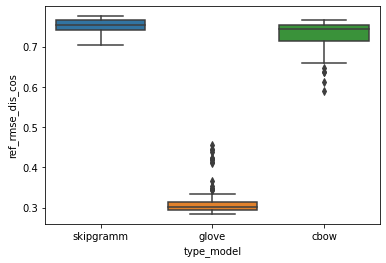

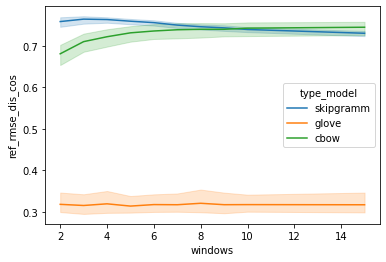

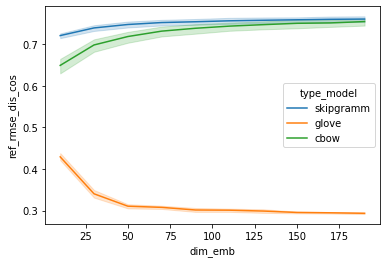

In [84]:
sns.boxplot(x="type_model",y="ref_rmse_dis_cos",data=df_evaluation)
plt.show()
sns.lineplot(x="windows",y="ref_rmse_dis_cos",hue="type_model",data=df_evaluation)
plt.show()
sns.lineplot(x="dim_emb",y="ref_rmse_dis_cos",hue="type_model",data=df_evaluation)
plt.show()

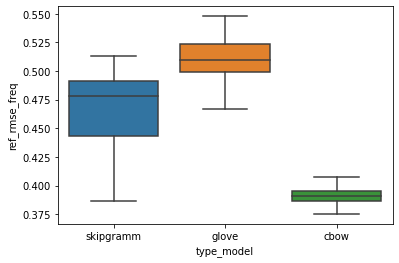

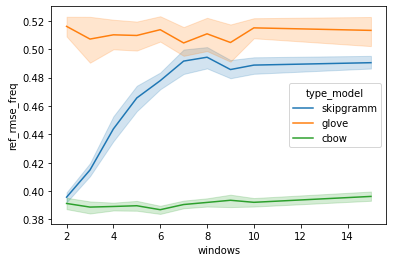

<AxesSubplot:xlabel='dim_emb', ylabel='ref_rmse_freq'>

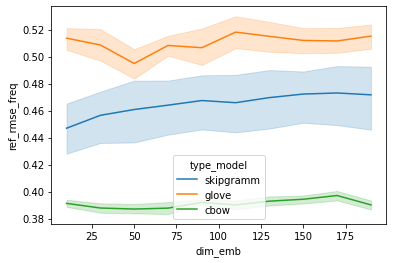

In [85]:
sns.boxplot(x="type_model",y="ref_rmse_freq",data=df_evaluation)
plt.show()
sns.lineplot(x="windows",y="ref_rmse_freq",hue="type_model",data=df_evaluation)
plt.show()
sns.lineplot(x="dim_emb",y="ref_rmse_freq",hue="type_model",data=df_evaluation)

In [86]:
# Best model
best_models = df_evaluation.loc[df_evaluation.groupby("type_model")["ref_rmse_dis_cos"].idxmin()]
print(best_models)
best_glove_filename = best_models.loc[best_models["type_model"] == "glove"]["models_filename"].values[0]
best_cbow_filename = best_models["models_filename"].loc[best_models["type_model"] == "cbow"].values[0]
best_skipgram_filename = best_models["models_filename"].loc[best_models["type_model"] == "skipgram"].values[0]

#Load model as Keyedvectors
best_glove = KeyedVectors.load_word2vec_format(f"training_models/{best_glove_filename}")
best_cbow = KeyedVectors.load_word2vec_format(f"training_models/{best_cbow_filename}")
best_skipgram = KeyedVectors.load_word2vec_format(f"training_models/{best_skipgram_filename}")

       models_filename type_model  windows  dim_emb   tag_mse  \
176       cbow_2_10.kv       cbow        2       10  0.058791   
278     glove_3_130.kv      glove        3      130  0.128135   
156  skipgramm_2_10.kv  skipgramm        2       10  0.091147   

     ref_err_dis_cos  ref_rmse_dis_cos  ref_err_moy_freq  ref_rmse_freq  
176        -0.474063          0.588684          0.229988       0.394898  
278         0.228017          0.284301          0.361207       0.485378  
156        -0.675125          0.702858          0.234600       0.387508  


In [87]:
lemm_test = "dechet"

print(f"Glove most similaire to {lemm_test}: \n{best_glove.most_similar(lemm_test)}\n")
print(f"Cbow most similaire to {lemm_test}: \n{best_cbow.most_similar(lemm_test)}\n")
print(f"skipgram most similaire to {lemm_test}: \n{best_skipgram.most_similar(lemm_test)}")

Glove most similaire to dechet: 
[('liberant', 0.3558439314365387), ('sortie', 0.31278690695762634), ('prototype', 0.3102320730686188), ('privilegiant', 0.30285215377807617), ('bas', 0.29694998264312744), ('humide', 0.2859032154083252), ('avocat', 0.28403207659721375), ('derivees', 0.27762261033058167), ('preparation', 0.2772093415260315), ('jadis', 0.27543434500694275)]

Cbow most similaire to dechet: 
[('politique', 0.9994907975196838), ('obliger', 0.9993322491645813), ('population', 0.9992029666900635), ('social', 0.9991233944892883), ('immeuble', 0.9990931153297424), ('agricole', 0.9989979863166809), ('energetiqu', 0.9989689588546753), ('être', 0.9989652037620544), ('route', 0.9989180564880371), ('foret', 0.9988776445388794)]

Skipgramm most similaire to dechet: 
[('poubelle', 0.9915301203727722), ('coefficient', 0.9899822473526001), ('veau', 0.9895740747451782), ('cuvette', 0.9894569516181946), ('present', 0.9886998534202576), ('reduirer', 0.9877720475196838), ('image', 0.98689264

In [83]:
# # Select best model
# shutil.copy2(src=f"../data/training_models/{best_glove_filename}",dst="../data/tunning/glove.kv")
# shutil.copy2(src=f"../data/training_models/{best_cbow_filename}",dst="../data/tunning/cbow.kv")
# shutil.copy2(src=f"../data/training_models/{best_skipgram_filename}",dst="../data/tunning/skipgram.kv")